# Phân tích hồi quy, giải thích và mô hình dự đoán số lượt xem của video trên Youtube

Import 1 vài thư viện hỗ trợ

In [263]:
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import ensemble
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

Load dữ liệu đã tiền xử lí

In [264]:
df = pd.read_csv(r'../datasets/data_train_test.csv')
df.head()

,Unnamed: 0,channel_id,channel_name,uploads,subscribers,video_views,channel_type,user_created,total_grade,social_blade_rank,...,channel_type_rank,subscribers_last_30_days,video_views_last_30_days,estimated_monthly_earnings,estimated_yearly_earnings,estimated_monthly_earnings_min,estimated_monthly_earnings_max,estimated_yearly_earnings_min,estimated_yearly_earnings_max,country_name
0,0,UCjfTi2zL7K6aX7_0EMIBukw,Televizioni Koha Tetovë,28878.0,101000.0,132074533.0,Entertainment,2013-02-09,B,235323.0,...,1914.0,1800.0,1221000.0,$305 - $4.9K,$3.7K - $58.6K,305.0,4900.0,3700.0,58600.0,Macedonia
1,1,UCFXJEYupgsUNDLLW338ctew,Out,675.0,60400.0,29418107.0,People,2020-12-27,B,443470.0,...,2082.0,1300.0,291130.0,$73 - $1.2K,$873 - $14K,73.0,1200.0,873.0,14000.0,Macedonia
2,2,UCOrLhuw4w09n_Uz_RKBwdUA,Diy Things,138.0,15500.0,8881452.0,Unknown,2011-10-24,B,184685.0,...,NaN,2300.0,1995000.0,$499 - $8K,$6K - $95.8K,499.0,8000.0,6000.0,95800.0,United States of America
3,3,UCLadFapyecCYAeuTqc12avA,Prof. Sam Vaknin,1186.0,276000.0,56546838.0,People,2009-02-11,B,234604.0,...,1469.0,7000.0,1342000.0,$335 - $5.4K,$4K - $64.4K,335.0,5400.0,4000.0,64400.0,Macedonia
4,4,UC2vecTBpi6mjJeHCdcax_0g,Grupa Maestro,112.0,36400.0,23938907.0,Music,2012-11-24,B,251756.0,...,2455.0,2300.0,1100000.0,$275 - $4.4K,$3.3K - $52.8K,275.0,4400.0,3300.0,52800.0,Macedonia


## Phân tích hồi quy, giải thích

Trực quan mối quan hệ giữa các thuộc tính 

C:\Users\Hy\AppData\Local\Temp\ipykernel_19832\1396631316.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  plt.matshow(df.corr(), fignum=f.number);


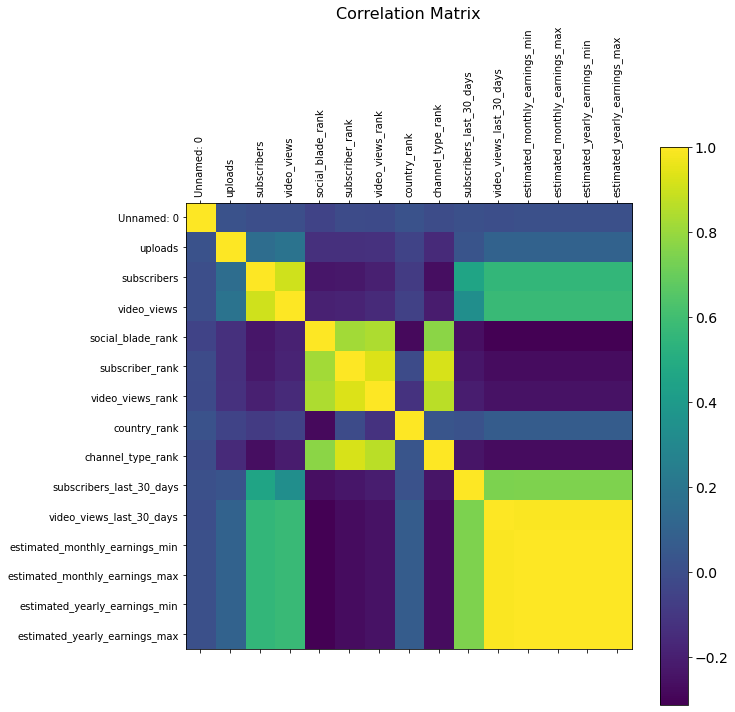

In [265]:
f = plt.figure(figsize=(10, 10))
plt.matshow(df.corr(), fignum=f.number);
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, rotation=90)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

Ta nhận thấy có các tương quan đồng biến giữa các thuộc tính với nhau, và có ít tương quan nghịch biến.
Ta tiếp tục xét sự tương quan đồng biến, với mức độ tương quan >= 0.5 như sau:

C:\Users\Hy\AppData\Local\Temp\ipykernel_19832\2790379350.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  plt.matshow(df.corr().clip(lower=0.5), fignum=f.number);


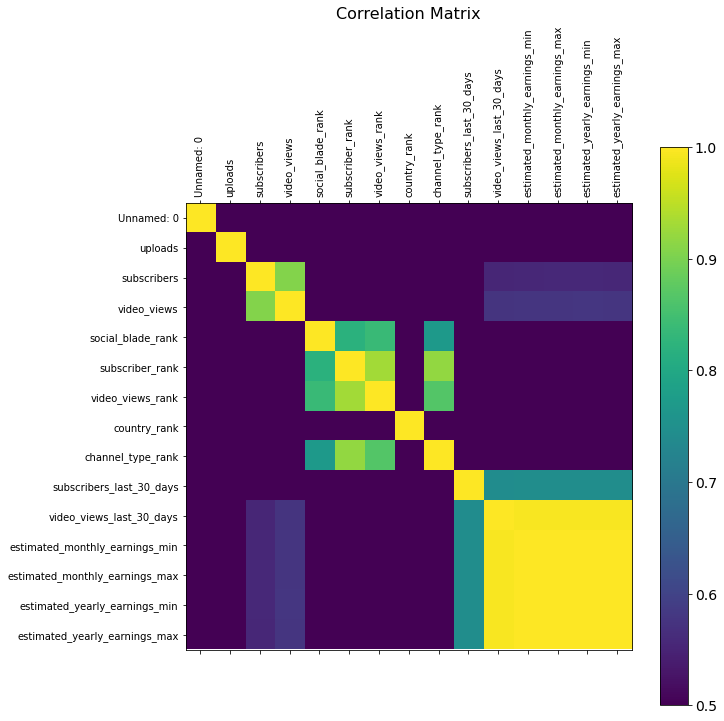

In [266]:
f = plt.figure(figsize=(10, 10))
plt.matshow(df.corr().clip(lower=0.5), fignum=f.number);
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, rotation=90)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

Nhận xét:
- Thuộc tính `subscribers` và `video_views` có sự liên quan đến nhau, vì thường kênh có nhiều lượt xem sẽ có nhiều người đăng kí và ngược lại.
- Các thuộc tính liên quan đến xếp hạng có sự tương quan đồng biến với nhau, điều này có thể xảy ra vì thông thường một kênh xếp hạng cao sẽ có các xếp hạng khác cũng tương đối cao, ở đây thì xếp hạng cao sẽ có lượt xem cao, lượt đăng kí cao, xếp hạng Xếp hạng theo thể loại cao (ngoại trừ `country_rank` vì xếp hạng theo khu vực không liên quan đến tính chất của các kênh youtube) và ngược lại.
- Các thuộc tính liên quan đến doanh thu có sự liên quan chặt chẽ với nhau, điều này hợp lí vì chúng được tính ra bằng công thức chứ không phản ánh giá trị thực tế (chỉ là dự đoán). Cụ thể là: (theo trang [SocialBlade](https://socialblade.com/youtube))
    - `estimated_monthly_earnings_min` = `video_views` * 0.25 / 1000 
    - `estimated_monthly_earnings_max` = `video_views` * 4.00 / 1000 
    - Dự đoán doanh thu tháng (min và max) đồng biến với dự đoán doanh thu của năm (min và max) là hợp lí.
- Ngoài ra thì cũng có sự tương quan đồng biến giữa các thuộc tính khác nhưng không quá chặt chẽ.

Ta sẽ tập trung xét sự tương quan giữa thuộc tính `subscriber` và `video_views`.

Hàm hỗ trợ vẽ biểu đồ scatter

In [267]:
def plot_scatter_sub_views(df):
    plt.scatter(df['subscribers'], df['video_views'])
    plt.title('Mối quan hệ giữa số lượng người đăng ký và số lượt xem', fontsize=16)
    plt.xlabel('Số lượng người đăng ký', fontsize=14)
    plt.ylabel('Số lượt xem', fontsize=14);

Vẽ biểu đồ

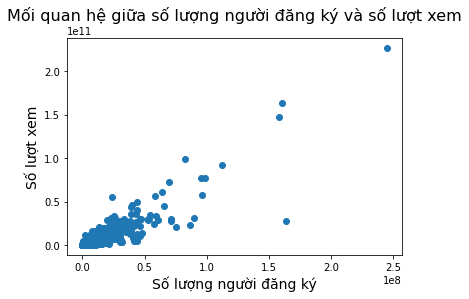

In [268]:
plot_scatter_sub_views(df)

Biểu đồ vẫn còn nhiều outliers. Tiến hành loại bỏ outliers bằng phương pháp Z-score:

In [269]:
def remove_outliers(df, column_name, threshold=3):
    z_scores = np.abs((df[column_name] - df[column_name].mean()) / df[column_name].std())
    return df[(z_scores < threshold)]


Loại bỏ outliers

In [270]:
df_no_outliers_zscore = remove_outliers(df, 'subscribers')
df_no_outliers_zscore = remove_outliers(df_no_outliers_zscore, 'video_views')

Vẽ lại biểu đồ sau khi loại bỏ outliers

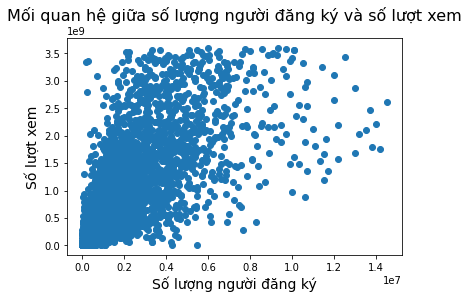

In [271]:
plot_scatter_sub_views(df_no_outliers_zscore)

Nhận xét:
- Nhìn chung thì ta thấy chúng có mối quan hệ đồng biến nhưng không quá chặt chẽ, do vẫn còn có các kênh youtube có nhiều lượt xem nhưng không có nhiều người đăng kí và ngược lại. 

- Ta có thể tìm hiểu kĩ hơn với từng thể loại kênh youtube. Sau đây là danh sách các thể loại kênh youtube:

In [272]:
df_no_outliers_zscore['channel_type'].value_counts()

Unknown          4312
Music            3665
People           3194
Entertainment    2490
Games            1465
News              781
Film              723
Education         645
Comedy            506
Sports            459
Travel            361
Howto             334
Tech              242
Autos             212
Nonprofit         211
Animals           103
Name: channel_type, dtype: int64

Hàm hỗ trợ vẽ biểu đồ scatter plot và đường hồi quy

In [273]:
def plot_scatter(ax, df, col1, col2, by_channel):
    ax.scatter(df[col1], df[col2])
    ax.set_xlabel(col1, fontsize=14)
    ax.set_ylabel(col2, fontsize=14)
    ax.set_xlim(0, 7e6)
    ax.set_ylim(0, 1e10)
    lin_reg = LinearRegression()
    lin_reg.fit(df[col1].values.reshape(-1, 1), df[col2].values.reshape(-1, 1))
    ax.plot(df[col1], lin_reg.predict(df[col1].values.reshape(-1, 1)), color='red')
    ax.set_title(f'{by_channel} - $R^2$ = {lin_reg.score(df[col1].values.reshape(-1, 1), df[col2].values.reshape(-1, 1)):.2f}', fontsize=16)


Với mỗi thể loại kênh, ta sẽ vẽ một biểu đồ scatter plot và đường hồi quy tương ứng.

`cols` là mảng gồm các thể loại kênh. 

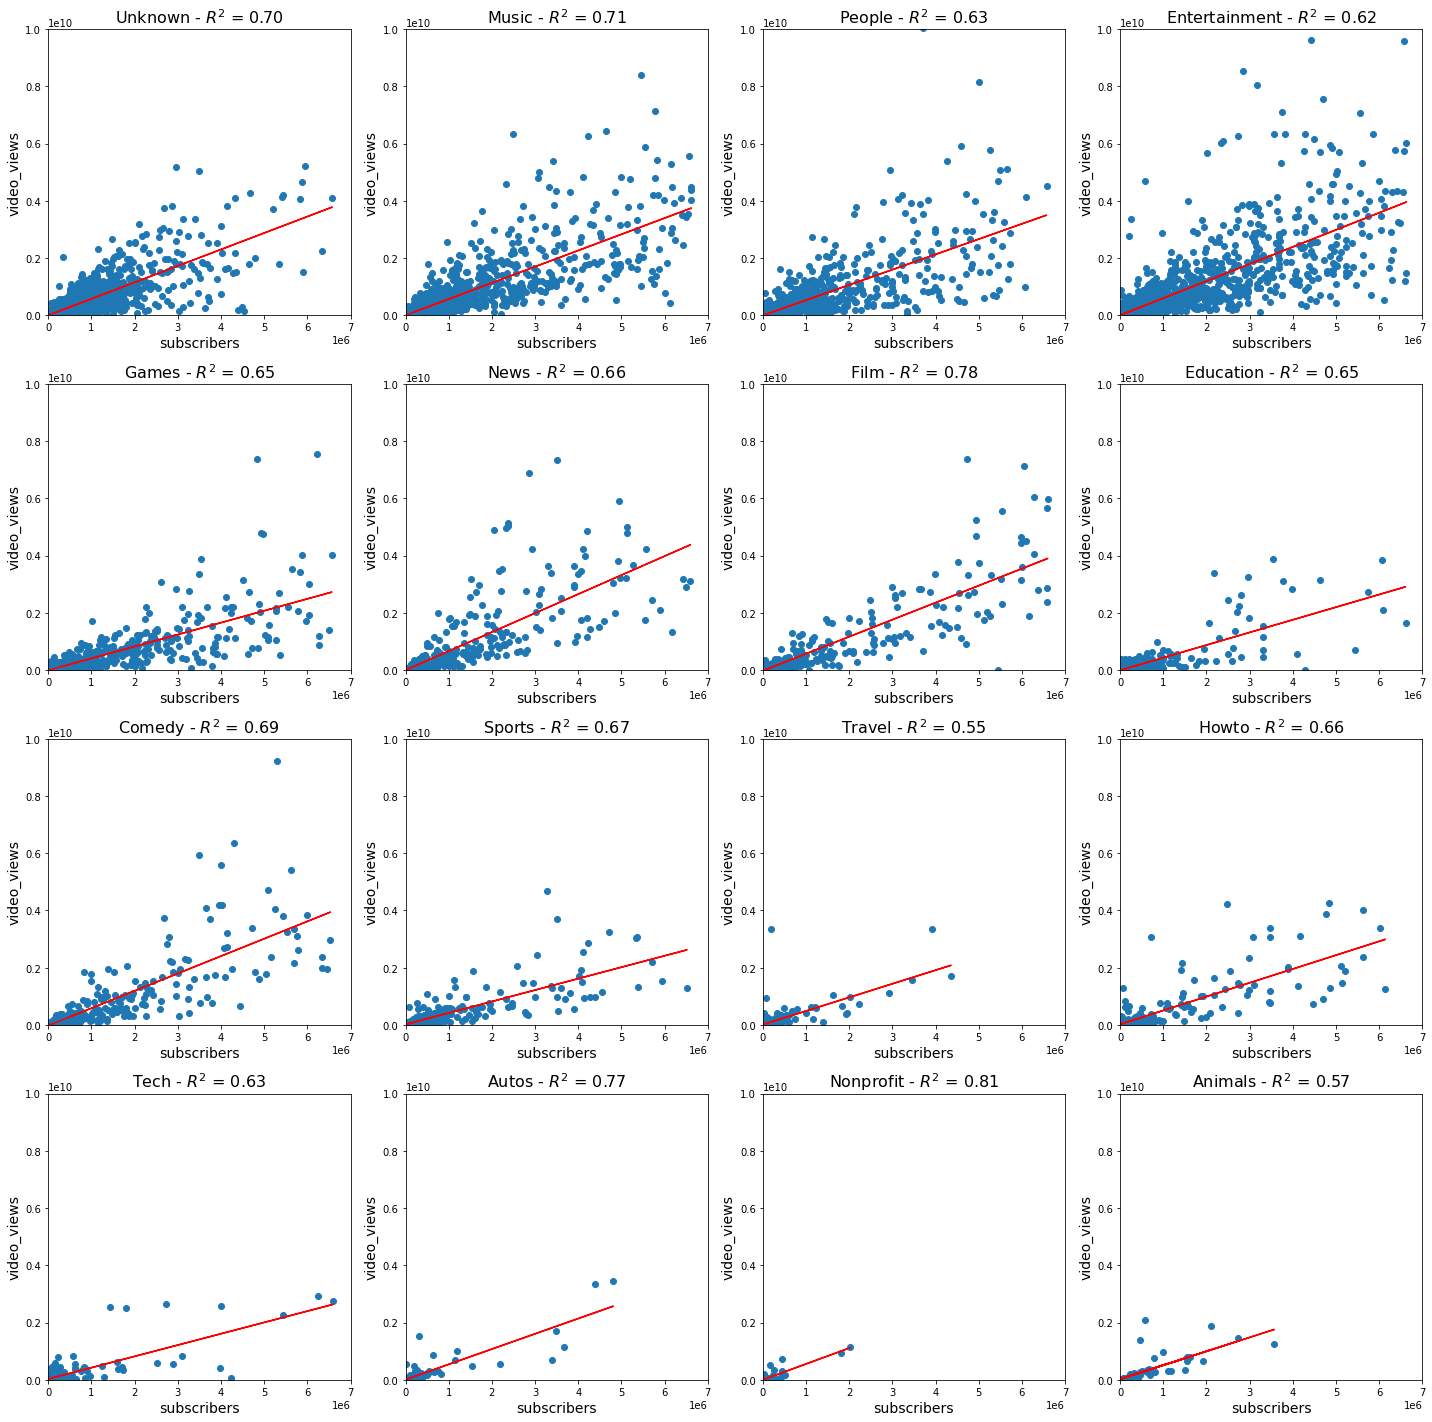

In [274]:
cols = ['Unknown','Music', 'People', 'Entertainment', 'Games', 'News', 'Film', 'Education', 
        'Comedy', 'Sports', 'Travel', 'Howto', 'Tech', 'Autos', 'Nonprofit', 'Animals']

fig, axs = plt.subplots(4, 4, figsize=(20, 20))

for i in range(len(cols)):
    df_no_outliers = remove_outliers(df, 'video_views')
    df_no_outliers = remove_outliers(df_no_outliers, 'subscribers')

    df_no_outliers = df_no_outliers[df_no_outliers['channel_type'] == cols[i]]
    plot_scatter(axs.flat[i], df_no_outliers, 'subscribers', 'video_views', cols[i])

plt.tight_layout()

Nhận xét:
- Các loại kênh Unknown, Music, People, Entertainment có số lượng kênh vượt trội so với các loại kênh khác.
- Nhìn chung mô hình các loại kênh đều có sự hồi quy số lượt xem với số người đăng ký nhất định. Có những kênh có hệ số $R^2$ cao như Autos và Nonprofit (nhưng lại có số sub và số view ít hẳn so với các thể loại khác), đa số mô hình các thể loại kênh có hệ số $R^2$ khoảng 0.6-0.7 và cũng có vài kênh thấp hơn (như Animal - 0.57 và Travel - 0.55). Một vài lí do:
    - Mô hình không chứa đủ thông tin để dự đoán số lượt xem dựa trên số người đăng ký.
    - Còn có các yếu tố khác ảnh hưởng đến số lượt xem như: số lượng video, thời lượng video, thời gian đăng tải, nội dung video, ...

Vì vậy chúng ta không thể dùng mô hình hồi quy tuyến tính cho dữ liệu này được. Theo biểu diễn dữ liệu dạng biểu đồ điểm, ta thấy chúng cũng không phù hợp cho các dạng hồi quy thông thường khác, do đó chúng ta cần sử dụng 1 mô hình hồi quy khác, ở đây chúng ta sẽ sử dụng Gradient Boosting để xây dựng mô hình hồi quy dự đoán số lượt xem của kênh, vì đây là mô hình hồi quy sử dụng nhiều thuộc tính để dự đoán kết quả, nhờ vậy đưa ra được kết quả dự đoán đáng tin cậy hơn so với các mô hình hồi quy thông thường.

## Dự đoán
### Mô hình Gradient Boosting trong việc dự đoán số lượng views của kênh youtube


Xem lại thông tin về dữ liệu, các cột và kiểu dữ liệu.

In [275]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20345 entries, 0 to 20344
Data columns (total 23 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      20345 non-null  int64  
 1   channel_id                      20345 non-null  object 
 2   channel_name                    20345 non-null  object 
 3   uploads                         20345 non-null  float64
 4   subscribers                     20345 non-null  float64
 5   video_views                     20345 non-null  float64
 6   channel_type                    20345 non-null  object 
 7   user_created                    20345 non-null  object 
 8   total_grade                     20345 non-null  object 
 9   social_blade_rank               20345 non-null  float64
 10  subscriber_rank                 20345 non-null  float64
 11  video_views_rank                20345 non-null  float64
 12  country_rank                    

#### Extract features
- Trong quá trình thực hiện việc dự đoán, nhóm đã thử chạy model với các cột có sẵn thì độ chính xác model cho toàn bộ dữ liệu rơi vào khoảng 0.75 - 0.8. Kết quả này chưa được cao nên nhóm đã thử thêm vào một số cột mới được tính toán dựa trên các cột đã có. Kết quả cho thấy độ chính xác đã tăng lên khoảng 0.8 - 0.9 trên toàn bộ dữ liệu. Nhóm đã thử thêm vào một số cột mới sau đây:

In [276]:
df['percentage_subscribed_last_30_days'] = df['subscribers_last_30_days'] / df['subscribers']
df['percentage_video_views_last_30_days'] = df['video_views_last_30_days'] / df['video_views']
df['average_views_per_video'] = df['video_views'] / df['uploads']
df['average_views_per_subscriber'] = df['video_views'] / df['subscribers']
df['user_created_dt'] = pd.to_datetime(df['user_created'].map(lambda d: re.sub(r'((st)|(nd)|(rd)|(th)),', '', d)), format='%b %d %Y', errors='coerce')
df['channel_age'] = (pd.to_datetime('today') - df['user_created_dt']).dt.days
df['average_views_per_day'] = df['video_views'] / df['channel_age']

- Chỉ lấy các cột là số

In [278]:
df = df.select_dtypes(['number'])

- Bỏ một số cột không cần dùng đến trong model

In [279]:
df = df.drop(
    columns=[
        "Unnamed: 0",
        "estimated_monthly_earnings_min",
        "estimated_monthly_earnings_max",
        "estimated_yearly_earnings_min",
        "estimated_yearly_earnings_max",
    ]
)

#### Chia dữ liệu thành 2 phần: train và test. 

In [280]:
y_feature = 'video_views'

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=[y_feature]), df[y_feature], test_size=0.2, random_state=42)

#### Train model và dự đoán trên tập test

In [281]:
reg = ensemble.HistGradientBoostingRegressor(random_state=42)
reg.fit(X_train, y_train)

print("Gradient boosting score:", reg.score(X_test, y_test))

Gradient boosting score: 0.9031794543204226


#### Lưu model vào file model.pkl để có thể gọi lại

In [282]:
# Save model to file
import pickle

# Re-train on all data
reg = ensemble.HistGradientBoostingRegressor()
reg.fit(df.drop(columns=[y_feature]), df[y_feature])

pickle.dump(reg, open('../models/gradient_boosting.pkl', 'wb+'))
df.to_csv('../datasets/data_regression.csv', index=False)